In [ ]:
!nvidia-smi

Tue Jun 23 13:15:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

In [ ]:
import pandas as pd
import numpy as np

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
dataset = pd.read_csv(r'Train.csv')
test_dataset = pd.read_csv('Test.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 616 entries, 0 to 615
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      616 non-null    object
 1   text    616 non-null    object
 2   label   616 non-null    object
dtypes: object(3)
memory usage: 14.6+ KB


In [ ]:
test_dataset

,ID,text
0,02V56KMO,How to overcome bad feelings and emotions
1,03BMGTOK,I feel like giving up in life
2,03LZVFM6,I was so depressed feel like got no strength t...
3,0EPULUM5,I feel so low especially since I had no one to...
4,0GM4C5GD,can i be successful when I am a drug addict?
...,...,...
304,Z9A6ACLK,Yes
305,ZDUOIGKN,My girlfriend dumped me
306,ZHQ60CCH,How can I go back to being my old self?
307,ZVIJMA4O,Is it true bhang is medicinal?


In [ ]:
dataset.head()

,ID,text,label
0,SUAVK39Z,I feel that it was better I dieAm happy,Depression
1,9JDAGUV3,Why do I get hallucinations?,Drugs
2,419WR1LQ,I am stresseed due to lack of financial suppor...,Depression
3,6UY7DX6Q,Why is life important?,Suicide
4,FYC0FTFB,How could I be helped to go through the depres...,Depression


In [ ]:
reviews = dataset['text'].values
sentiments = dataset['label'].values

train_reviews = reviews[:550]
train_sentiments = sentiments[:550]

test_reviews = reviews[550:]
test_sentiments = sentiments[550:]

In [ ]:
test_sentiments

array(['Depression', 'Depression', 'Suicide', 'Depression', 'Depression',
       'Depression', 'Depression', 'Alcohol', 'Drugs', 'Depression',
       'Depression', 'Alcohol', 'Depression', 'Depression', 'Suicide',
       'Alcohol', 'Alcohol', 'Alcohol', 'Alcohol', 'Alcohol', 'Drugs',
       'Depression', 'Suicide', 'Depression', 'Alcohol', 'Depression',
       'Depression', 'Depression', 'Depression', 'Drugs', 'Drugs',
       'Depression', 'Suicide', 'Depression', 'Depression', 'Alcohol',
       'Depression', 'Depression', 'Alcohol', 'Depression', 'Drugs',
       'Depression', 'Depression', 'Depression', 'Drugs', 'Depression',
       'Depression', 'Drugs', 'Suicide', 'Alcohol', 'Depression',
       'Suicide', 'Suicide', 'Depression', 'Drugs', 'Suicide', 'Alcohol',
       'Drugs', 'Depression', 'Suicide', 'Depression', 'Alcohol',
       'Suicide', 'Alcohol', 'Depression', 'Depression'], dtype=object)

In [ ]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [ ]:

%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 66/66 [00:00<00:00, 7076.46it/s]

CPU times: user 85.4 ms, sys: 7.72 ms, total: 93.1 ms
Wall time: 87.5 ms


In [ ]:
import tensorflow as tf

t = tf.keras.preprocessing.text.Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [ ]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('incidencesof', 799), ('<PAD>', 0), 1)

In [ ]:
train_sequences = t.texts_to_sequences(norm_train_reviews)
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [ ]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=800
Number of Documents=550


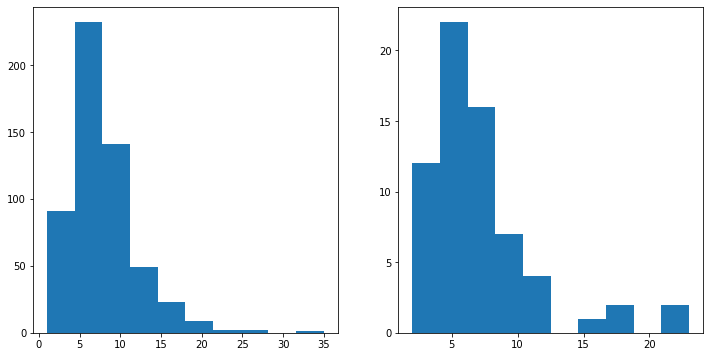

In [ ]:

import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

In [ ]:

MAX_SEQUENCE_LENGTH = 300

# pad dataset to a maximum review length in words
X_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((550, 300), (66, 300))

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
num_classes=4

In [ ]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [ ]:
VOCAB_SIZE = len(t.word_index)

In [ ]:
EMBEDDING_DIM = 300 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
# model.add(tf.keras.layers.SpatialDropout1D(0.1))
model.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 300)          240000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_12 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 1028      
Total params: 493,700
Trainable params: 493,700
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 8
EPOCHS = 10

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=2,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
          callbacks=[es],
          shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
62/62 [==============================] - 1s 23ms/step - loss: 1.0726 - accuracy: 0.6121 - val_loss: 0.8434 - val_accuracy: 0.7091
Epoch 2/10
62/62 [==============================] - 1s 17ms/step - loss: 0.5358 - accuracy: 0.7838 - val_loss: 0.6502 - val_accuracy: 0.7818
Epoch 3/10
62/62 [==============================] - 1s 17ms/step - loss: 0.2363 - accuracy: 0.9071 - val_loss: 0.6263 - val_accuracy: 0.8000
Epoch 4/10
62/62 [==============================] - 1s 17ms/step - loss: 0.0936 - accuracy: 0.9778 - val_loss: 0.6146 - val_accuracy: 0.8364
Epoch 5/10
62/62 [==============================] - 1s 17ms/step - loss: 0.0684 - accuracy: 0.9818 - val_loss: 0.6857 - val_accuracy: 0.8000
Epoch 6/10
62/62 [==============================] - 1s 17ms/step - loss: 0.0398 - accuracy: 0.9859 - val_loss: 0.6501 - val_accuracy: 0.8182
Epoch 00006: early stopping


In [ ]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

3/3 [==============================] - 0s 6ms/step - loss: 1.0863 - accuracy: 0.6970
Accuracy: 69.70%


In [ ]:
predictions = model.predict_classes(X_test).ravel()
predictions[:10]

array([1, 1, 0, 1, 1, 1, 1, 3, 2, 1])

In [ ]:
predictions = np.array(predictions,dtype = np.str)
for i in range(len(predictions)):
  if predictions[i]== '0':
    predictions[i]='Alcohol'
  elif predictions[i]=='1':
    predictions[i]='Depression'
  elif predictions[i]=='2':
    predictions[i]='Drugs'
  else:
    predictions[i]='Suicide'
predictions[:10]

array(['Depression', 'Depression', 'Alcohol', 'Depression', 'Depression',
       'Depression', 'Depression', 'Suicide', 'Drugs', 'Depression'],
      dtype='<U21')

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['Alcohol','Depression','Drugs','Suicide']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

     Alcohol       0.57      0.57      0.57        14
  Depression       0.79      0.91      0.85        33
       Drugs       0.67      0.44      0.53         9
     Suicide       0.50      0.40      0.44        10

    accuracy                           0.70        66
   macro avg       0.63      0.58      0.60        66
weighted avg       0.68      0.70      0.68        66



,Alcohol,Depression,Drugs,Suicide
Alcohol,8,2,1,3
Depression,1,30,1,1
Drugs,4,1,4,0
Suicide,1,5,0,4


# Stacked LSTM

In [ ]:
EMBEDDING_DIM = 100 # dimension for dense embeddings for each token
LSTM_DIM = 128 # total LSTM units

model2 = tf.keras.models.Sequential()
model2.add(tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
# model2.add(tf.keras.layers.SpatialDropout1D(0.1))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=True))
model2.add(tf.keras.layers.LSTM(LSTM_DIM, return_sequences=False))
model2.add(tf.keras.layers.Dense(128, activation='relu'))
model2.add(tf.keras.layers.Dense(4, activation="softmax"))

model2.compile(loss="sparse_categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])
model2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 300, 100)          80000     
_________________________________________________________________
lstm_17 (LSTM)               (None, 300, 128)          117248    
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 4)                 516       
Total params: 345,860
Trainable params: 345,860
Non-trainable params: 0
_________________________________________________________________


In [ ]:
batch_size = 64
EPOCHS = 20

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5,
                                      restore_best_weights=True,
                                      verbose=1)

model2.fit(X_train, y_train, epochs=EPOCHS, batch_size=batch_size, 
           callbacks=[es],
           shuffle=True, validation_split=0.1, verbose=2)

Epoch 1/20
8/8 - 0s - loss: 0.1715 - accuracy: 0.9576 - val_loss: 0.7310 - val_accuracy: 0.7455
Epoch 2/20
8/8 - 0s - loss: 0.1248 - accuracy: 0.9616 - val_loss: 0.8095 - val_accuracy: 0.7636
Epoch 3/20
8/8 - 0s - loss: 0.0871 - accuracy: 0.9717 - val_loss: 0.8789 - val_accuracy: 0.7455
Epoch 4/20
8/8 - 0s - loss: 0.0940 - accuracy: 0.9636 - val_loss: 0.9854 - val_accuracy: 0.7455
Epoch 5/20
8/8 - 0s - loss: 0.0668 - accuracy: 0.9798 - val_loss: 0.9193 - val_accuracy: 0.7636
Epoch 6/20
Restoring model weights from the end of the best epoch.
8/8 - 0s - loss: 0.0531 - accuracy: 0.9818 - val_loss: 0.9955 - val_accuracy: 0.7455
Epoch 00006: early stopping


In [ ]:

# Final evaluation of the model
scores = model2.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

3/3 [==============================] - 0s 8ms/step - loss: 1.0400 - accuracy: 0.6667
Accuracy: 66.67%
